# DREAM EXPERIMENT: C/S ratio vs inclination of BGO

Importing modules

In [43]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline, BSpline
import scipy.optimize as optim
import scipy.stats as stats
import os
from IPython.display import clear_output

#### Loading files & first analysis:

In [44]:
# directory
directory = '../datasets/Total/'
preFileName = 'numbers'
postFileName = '.txt'

# angles:
theta_names = ['0','P15','P20','P25','P30','P40']
angles = [0,15,20,25,30,40]
fileNames = [preFileName + i + postFileName for i in theta_names]

#### Landau-Vavilov distribution:
A good limit of the Landau distribution is the Moyal pdf:
$$ p(x) = \frac{1}{\sqrt{2\pi}} \exp \left( -\frac{x-e^{-x}}{2} \right) $$

In [55]:
# Moyal distribution + parameters
def f(x,mean,normalization,form):
    return normalization*stats.moyal.pdf(form*(x-mean))

#### Plot C/S vs angle

## Mean method
We use a dataset with the BGO crystal at a certain angle $\theta_0$ and we make the histogram of $N_C$, the number of detected Cherenkov events, and the same for scintillation photons. The we take the mode of these histograms and we evaluate the ratio.


CHERENKOV:
mode = 83.03999999999999 +/- inf
Normalization = 0.02216611627294907 +/- inf
Form factor = 70.0 +/- inf

SCINTILLATION:
mode = 6709.39 +/- inf
Normalization = 0.7 +/- inf
Form factor = 0.0002748628908106419 +/- inf


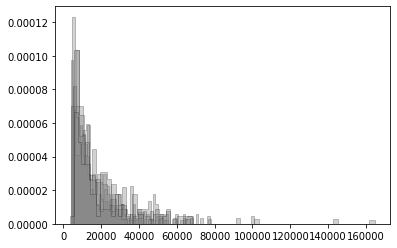

In [67]:
CSratioM, Delta_CSratioM = [],[]
nbins = 50

#loading files
for name in fileNames:
    numberC_raw, totalC, numberS_raw, totalS = np.loadtxt(directory+name, unpack=True, usecols=(0,1,2,3))
    
    numberC, numberS = [],[]
    for i, val in enumerate(numberC_raw):
        if totalC[i] > 1500 and totalS[i] > 125000:
            numberC.append(val)
            numberS.append(numberS_raw[i])
    
    # now need to make the histo of C and S values
    bin_heightsC, bin_bordersC = np.histogram(numberC, bins=nbins, density=True)
    bin_centersC = bin_bordersC[:-1] + 0.5*np.diff(bin_bordersC)
    
    bin_heightsS, bin_bordersS = np.histogram(numberS, bins=nbins, density=True)
    bin_centersS = bin_bordersS[:-1] + 0.5*np.diff(bin_bordersS)
    
    # plot the histo
    #fig = plt.figure(111, figsize=(10,5), dpi=250)
    plt.hist(numberS, bins=nbins, label='BGO crystal', histtype="stepfilled",
        color='gray', ec='black', alpha=0.35, lw=0.65, density=True)
    
    # landau fit
    bin_heightsC = list(bin_heightsC)
    bin_heightsS = list(bin_heightsS)
    idxC = bin_heightsC.index(max(bin_heightsC))
    idxS = bin_heightsS.index(max(bin_heightsS))
    [mode_C, normalization_C, form_C], covariance_C = optim.curve_fit(f, bin_centersC, bin_heightsC, p0=[bin_centersC[idxC],max(bin_heightsC),70])
    [mode_S, form_S, normalization_S], covariance_S = optim.curve_fit(f, bin_centersS, bin_heightsS, p0=[bin_centersS[idxS],max(bin_heightsS),0.7])
    
    # print results
    clear_output(wait=True)
    print("\nCHERENKOV:")
    print("mode = {0} +/- {1}".format(mode_C,covariance_C[0][0]))
    print("Normalization = {0} +/- {1}".format(normalization_C,covariance_C[1][1]))
    print("Form factor = {0} +/- {1}".format(form_C,covariance_C[2][2]))
    
    print("\nSCINTILLATION:")
    print("mode = {0} +/- {1}".format(mode_S,covariance_S[0][0]))
    print("Normalization = {0} +/- {1}".format(normalization_S,covariance_S[1][1]))
    print("Form factor = {0} +/- {1}".format(form_S,covariance_S[2][2]))
    
    CSratioM.append(mode_C/mode_S)
    

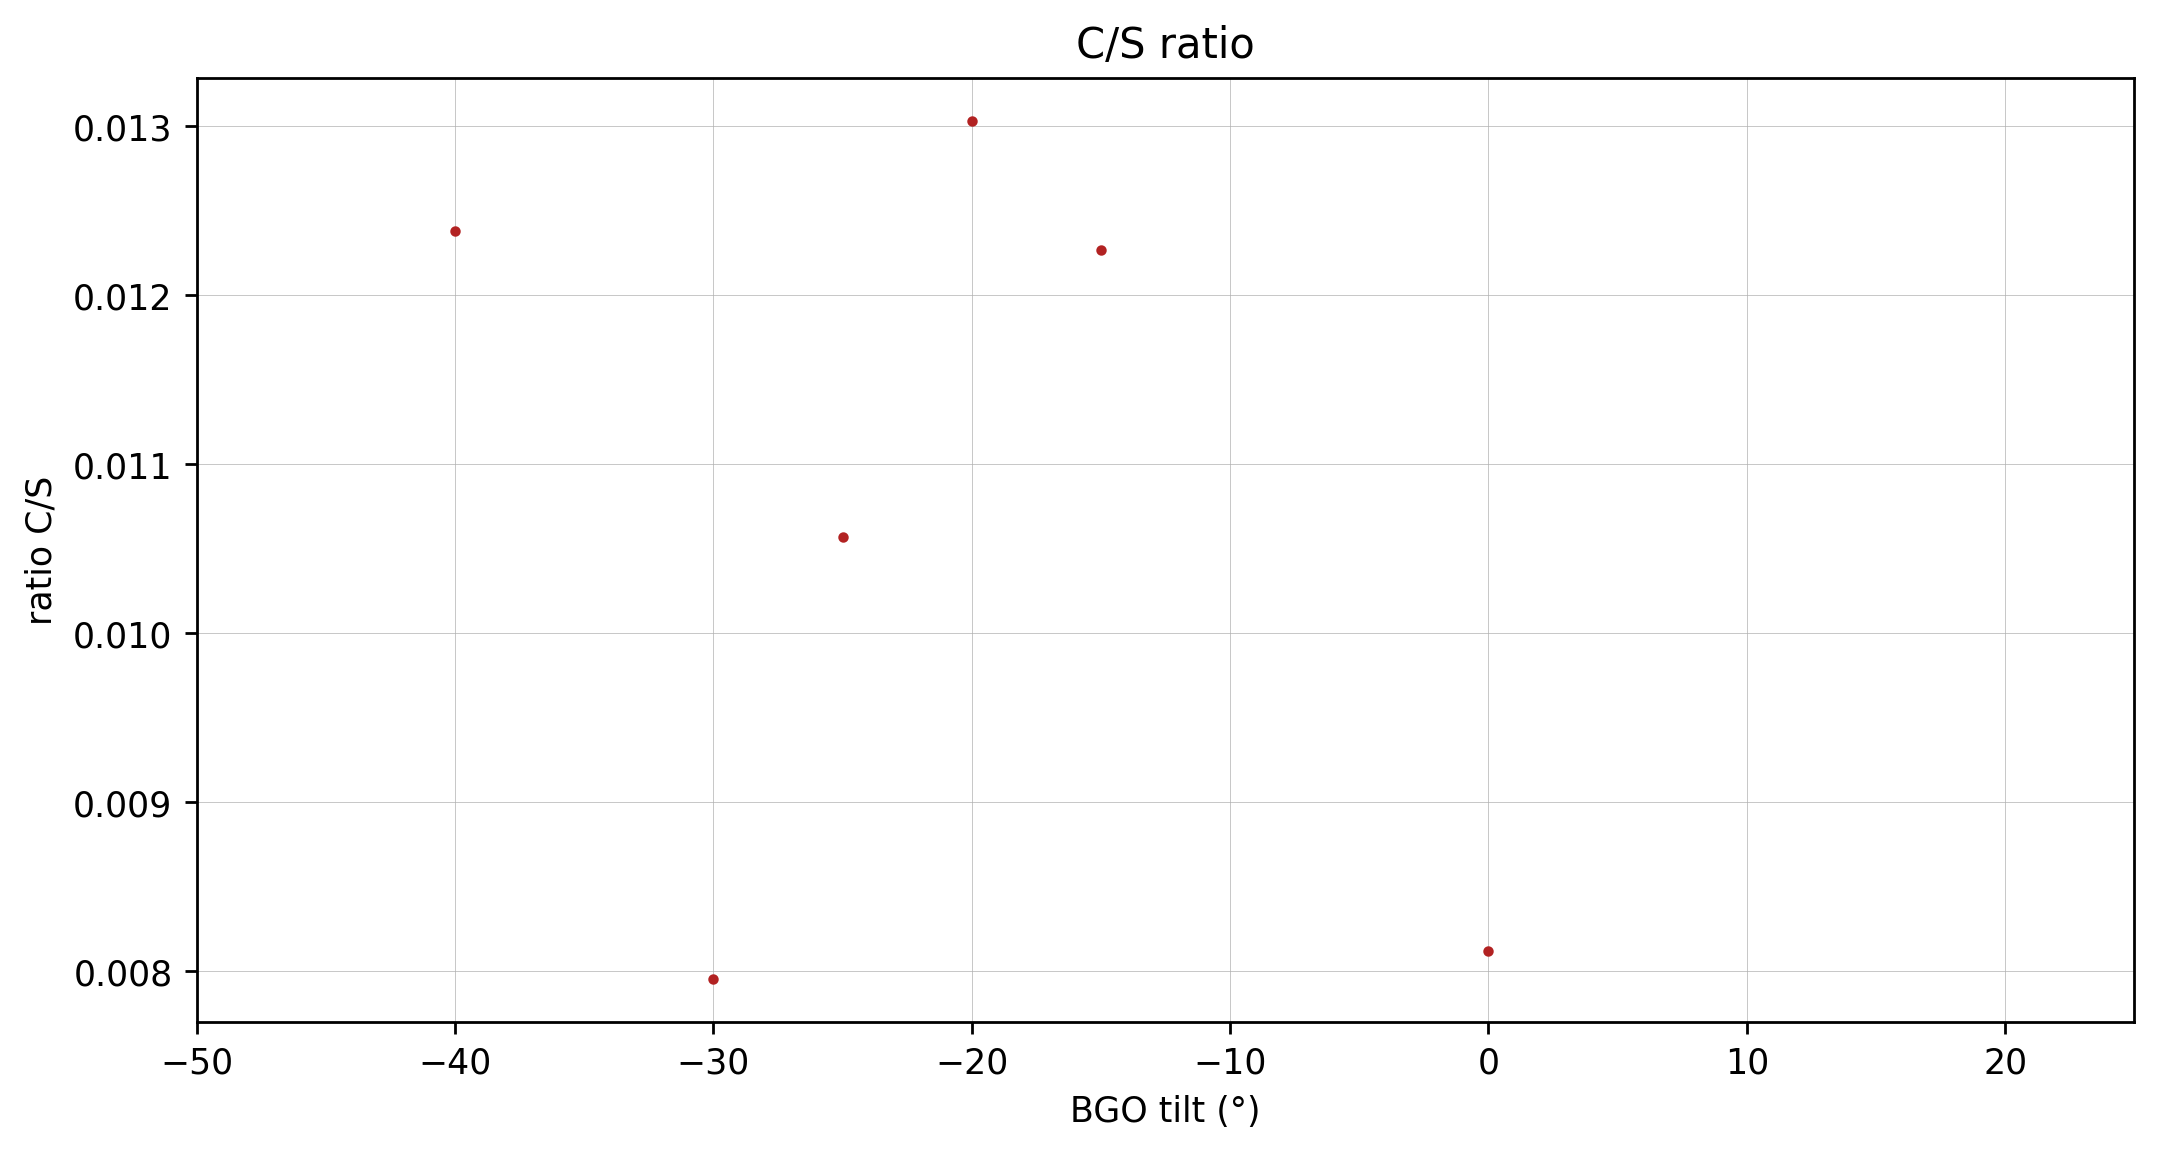

In [68]:
# flip angles
flipped_angles = []
for theta in angles:
    flipped_angles.append(-theta)

# prepare the figure
fig = plt.figure(111, figsize=(10,5), dpi=250)

# plot data
plt.errorbar(flipped_angles, CSratioM, yerr=None, xerr=None, label='C/S number of $\gamma$s',
             marker='o', markersize=2, color="firebrick", ecolor="black", lw=0, elinewidth=0.5)

# visualize
plt.title('C/S ratio')
plt.xlabel('BGO tilt (°)')
plt.ylabel('ratio C/S')
plt.xlim([-50,25])
plt.grid(linestyle='-', linewidth=0.2)
plt.show()

## Event per event method
We use a dataset with the BGO crystal at a certain angle $\theta_0$ and, for each detected event, we evaluate $C/S = \frac{N_C}{N_S}$, i.e. the number of detected Cherenkov vs scintillation photons. Then make an histogram of these $C/S$ values and we take the mode (most frequent) value of this histo with its relative error.

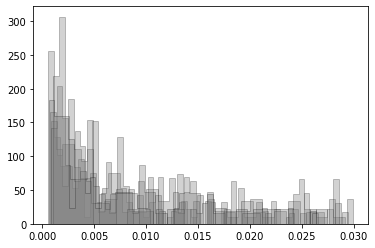

In [69]:
CSratioEE, Delta_CSratioEE = [],[]

#loading files
for name in fileNames:
    numberC_raw, totalC, numberS_raw, totalS = np.loadtxt(directory+name, unpack=True, usecols=(0,1,2,3))
    
    numberC, numberS = [],[]
    for i, val in enumerate(numberC_raw):
        if totalC[i] > 1500 and totalS[i] > 125000:
            numberC.append(val)
            numberS.append(numberS_raw[i])
    
    # arrays containing ratios
    ratio, delta_ratioSquare = [],[]
    # fill arrays with ratios and errors
    for idx, value in enumerate(numberC):
        r = value/numberS[idx]
        if r <= 0.03:
            ratio.append(r)
            delta_ratioSquare.append(r*r*( 1/value + 1/numberS[idx] ) )
    
    # now need to make the histo of C/S values
    # extrapolate data from histogram
    bin_heights, bin_borders = np.histogram(ratio, bins=100, density=True)
    bin_centers = bin_borders[:-1] + 0.5*np.diff(bin_borders)
    
    # landau fit
    [mean_EE, form_EE, normalization_EE], covariance_EE = optim.curve_fit(f, bin_centers, bin_heights, p0=[max(bin_heights),0.4,max(bin_heights)])
    
    # print results
    print("Results of fit:\nmode = {0} +/- {1}".format(mean_EE,covariance_EE[0][0]))
    print("Form factor = {0} +/- {1}".format(form_EE,covariance_EE[1][1]))
    print("Normalization = {0} +/- {1}".format(normalization_EE,covariance_EE[2][2]))
    
    # plot the histo
    plt.hist(ratio, bins=50, label='BGO crystal', histtype="stepfilled",
        color='gray', ec='black', alpha=0.35, lw=0.65, density=True)
    clear_output(wait=True)
    
    CSratioEE.append(max(bin_heights))
    

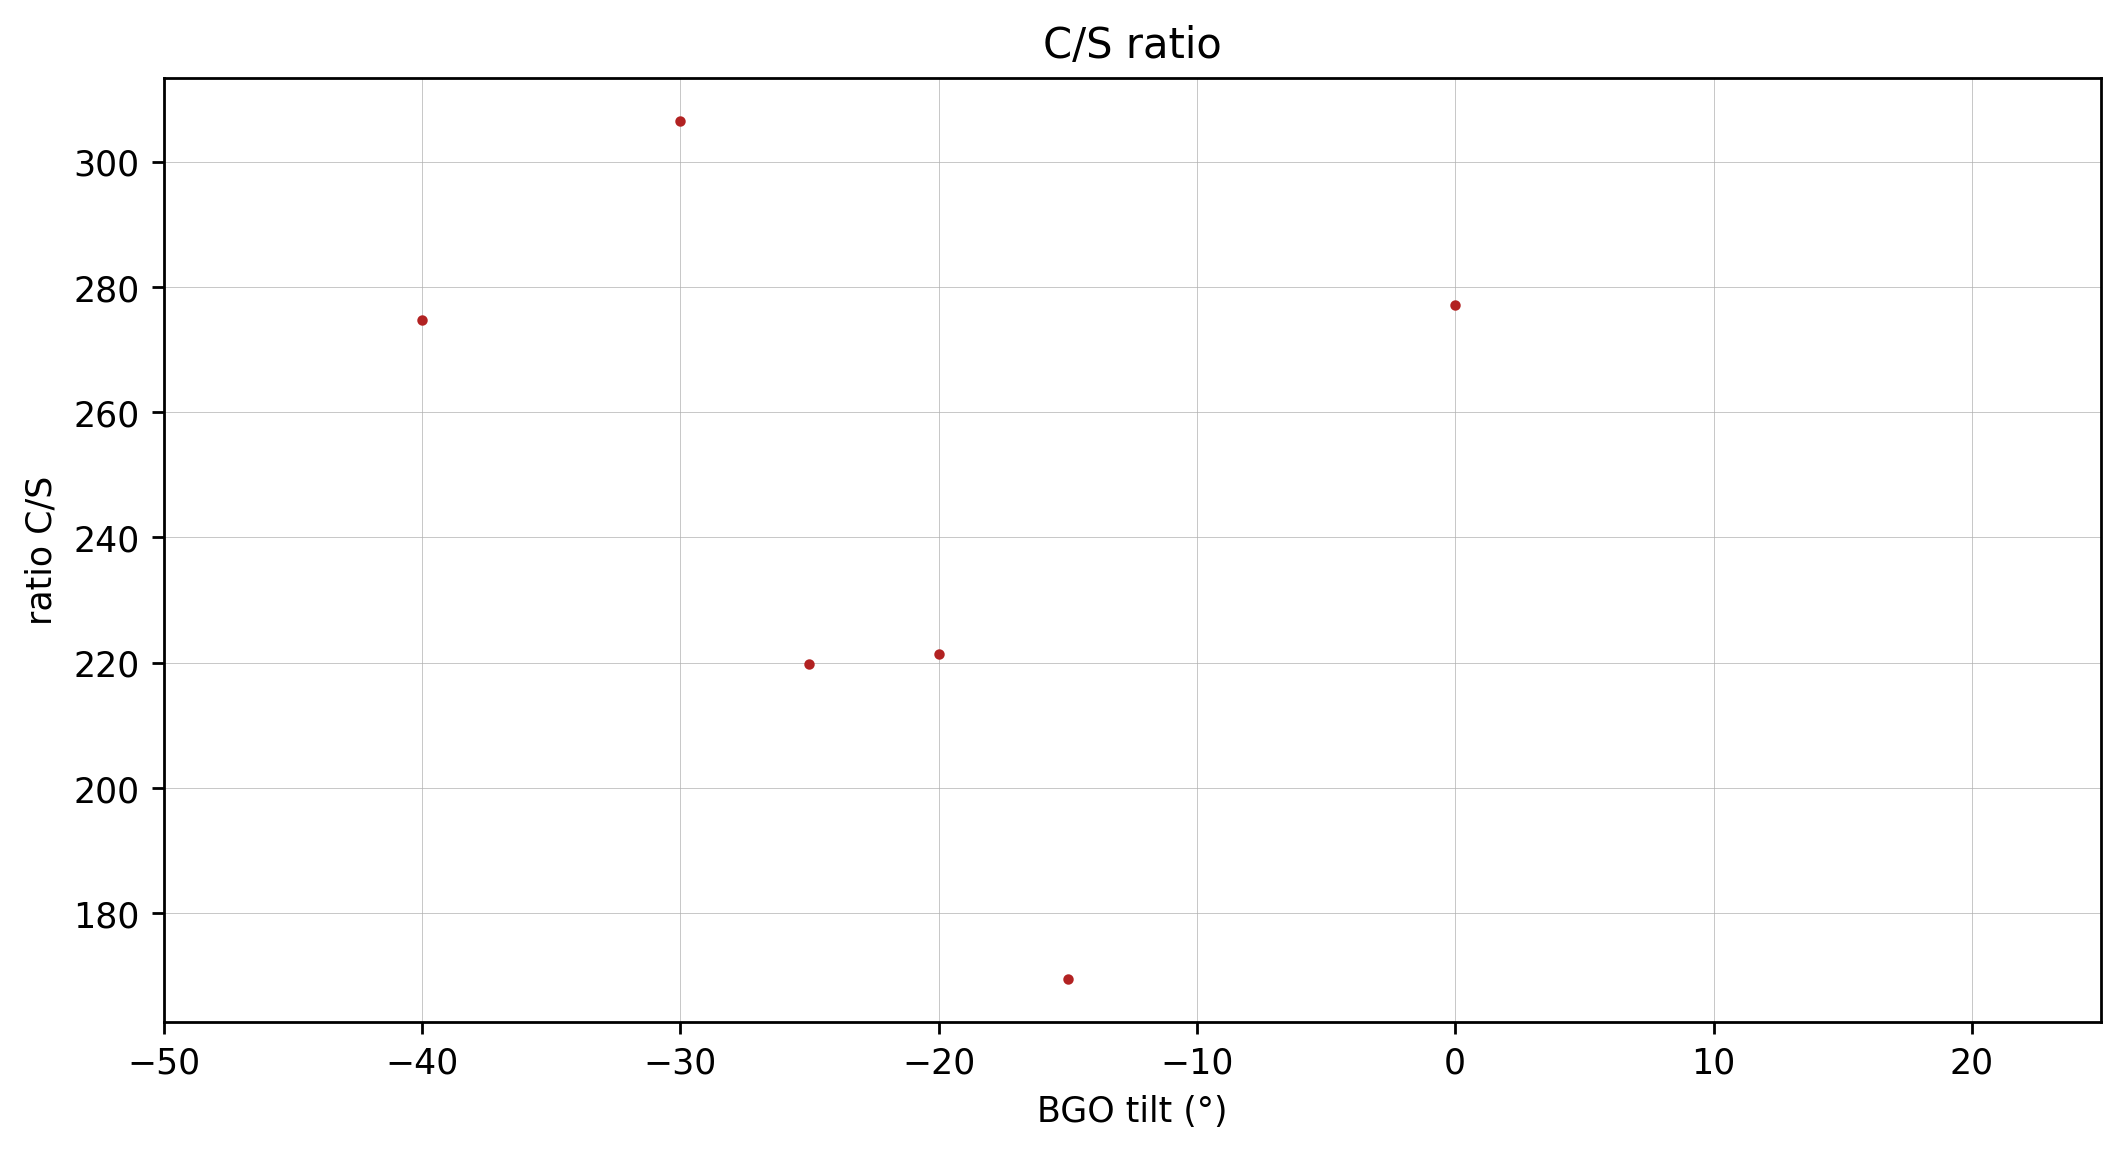

In [70]:
# flip angles
flipped_angles = []
for theta in angles:
    flipped_angles.append(-theta)

# prepare the figure
fig = plt.figure(111, figsize=(10,5), dpi=250)

# plot data
plt.errorbar(flipped_angles, CSratioEE, yerr=None, xerr=None, label='C/S number of $\gamma$s',
             marker='o', markersize=2, color="firebrick", ecolor="black", lw=0, elinewidth=0.5)

# visualize
plt.title('C/S ratio')
plt.xlabel('BGO tilt (°)')
plt.ylabel('ratio C/S')
plt.xlim([-50,25])
plt.grid(linestyle='-', linewidth=0.2)
plt.show()